# Machine Translation Quality Estimation Task 2020


## Initial Setup

* Check the GPU memory: BERT will require 16GB
* Mount your Google Drive where the data will be downloaded and your trained models will be saved
* Download spaCy, gloVe and FastText for different pre-trained embeddings
* Import any required libraries and define helper functions.

In [60]:
# Check on the type and capacity of the GPU
# Bert will require 16GB
import torch
import sys

print(sys.version)

cuda_dev = '0' # GPU device 0 (can be changed if multiple GPUs are available)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:" + cuda_dev if use_cuda else "cpu")

print('Device: ' + str(device))
if use_cuda:
    print('GPU: ' + str(torch.cuda.get_device_name(int(cuda_dev))))    

3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Device: cuda:0
GPU: Tesla T4


In [61]:
from google.colab import files, drive
%matplotlib inline

# Mount your google drive to get the data from
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Install requirements for the coursework
!pip install transformers
!pip install --upgrade torchtext # we require 0.5.0 for torchtext
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil

     |████████████████████████████████| 501kB 4.9MB/s 
     |████████████████████████████████| 870kB 38.2MB/s 
     |████████████████████████████████| 3.7MB 51.0MB/s 
     |████████████████████████████████| 1.0MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=400193ec0b8930a3d209339175b9c16875735707ab0552dccd07b91876903428
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses
     |████████████████████████████████| 81kB 3.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=d62b95b2efe540181650784fb2c179fb1c73cd9514b8ed56f83e155812827334
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


In [4]:
import spacy

# Download spacy model for english
!spacy download en_core_web_md
!spacy link en_core_web_md en300

# Download chinese stopwords
!wget -c https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt

     |████████████████████████████████| 95.4MB 100.4MB/s 
  Created wheel for en-core-web-md: filename=en_core_web_md-2.1.0-cp36-none-any.whl size=97126236 sha256=911f0f8ad14e09c9366ac007f98da2a8e3cafd76a8874f567c0cb29cb6258c49
  Stored in directory: /tmp/pip-ephem-wheel-cache-dqoagttq/wheels/c1/2c/5f/fd7f3ec336bf97b0809c86264d2831c5dfb00fc2e239d1bb01
Successfully built en-core-web-md
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_md -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en300
You can now load the model via spacy.load('en300')
--2020-02-28 18:14:12--  https://github.com/Tony607/Chinese_sentiment_analysis/blob/master/data/chinese_stop_words.txt
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Savin

In [62]:
# Import libraries

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import time
import io
import os
from os.path import exists

# Libraries for pre-processing
import spacy
import jieba
import string
import inflect
import re
from nltk import download
from nltk.corpus import stopwords

# Libraries for pre-trained embeddings
from torch.utils.data import DataLoader, TensorDataset, sampler, ConcatDataset
from torchtext.vocab import FastText, GloVe, Vectors
from gensim.models import Word2Vec, KeyedVectors

# Download english stopwords
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Download Data



In [0]:
# Download and unzip the data

language = 'enzh' #'ende' or 'enzh'

file_name = language + '_data.zip'

if language == 'enzh' and not exists(file_name):
    !wget -O enzh_data.zip https://competitions.codalab.org/my/datasets/download/03e23bd7-8084-4542-997b-6a1ca6dd8a5f
    !unzip enzh_data.zip

elif language == 'ende' and not exists(file_name):
    !wget -O ende_data.zip https://competitions.codalab.org/my/datasets/download/c748d2c0-d6be-4e36-9f12-ca0e88819c4d
    !unzip ende_data.zip
 

## Pre-processing

* There are two different pre-processing functions - one for pre-trained embeddings e.g. GloVe, FastText, and the other for pre-trained transformers.

### Pre-processing for Word2Vec Embeddings
* Lowercase (English only)
* Lemmitization (English only)
* Removing stopwords

### Pre-processing for Transformers
* BERT
  * Keep uppercase
  * Add special tokens

In [0]:
# Download pre-trained embeddings
stop_words_en = set(stopwords.words('english'))
stop_words_zh = [line.rstrip() for line in open(os.path.expanduser('./chinese_stop_words.txt'), "r", encoding="utf-8")]
nlp = spacy.load('en300')
p = inflect.engine()

In [0]:
def open_data_files(language='enzh', data_type='train'):
    """
    Open data text files and return its mt, src and scores lists. If data_type
    is 'test', scores is omitted.

    :param langauge: language model of the data files. Options: 'enzh', 'ende'
    :param data_type: type of the dataset. Options: 'train', 'dev', 'test'

    :return: np.array, np.array, torch.Tensor (last one omitted
             if data_type='test')
    """
    file_path = os.path.expanduser("./")

    # Read the data files
    mt = pd.read_csv(file_path + '%s.%s.mt' % (data_type, language), header=None, sep='/n', engine='python')[0].to_numpy()
    src = pd.read_csv(file_path + '%s.%s.src' % (data_type, language), header=None, sep='/n', engine='python')[0].to_numpy()

    if data_type == 'test': # test data doesn't have scores
        scores = None
    else:
        scores = torch.from_numpy(np.genfromtxt(file_path + '%s.%s.scores' % (data_type, language), dtype=np.float64, delimiter='/n')).unsqueeze(1)

    return src, mt, scores
    

def preprocessing(sentence, lang, remove_stop_word=True):
    """
    Preprocesses the sentence by lowercasing, lemmatizing (if not chinese),
    removing stopwords and tokenizing.

    :param sentence: str object. Sentence to preprocess
    :param lang: language of the sentnece. Options: 'zh', 'en'
    :remove_stop_word: if True, remove stopwords

    :return: list of tokens of the sentence
    """
    if lang == 'zh':
        line = jieba.lcut(sentence, cut_all=True)
        if remove_stop_word:
            line = [word for word in line if word not in stop_words_zh]
        line = [e for e in line if e.isalnum()] # True if all characters in the string are alphanumeric (no whitespace etc.)
    elif lang == 'en':
        text = sentence.lower()
        line = [token.lemma_ for token in nlp.tokenizer(text)]
        if remove_stop_word:
            line = [word for word in line if word not in stop_words_en]

    # Convert numbers into english alphabets
    new_line = []
    for word in line:
        if word.isdigit():
            new_line += p.number_to_words(word, group=1).replace(',', '').split()
        else:
            new_line.append(word)
    return line


def get_sentence_vector(tokens_src, tokens_mt, vec_src, vec_mt, max_len):
    """
    Converts each token of the sentence to its word embedding (vector). If the
    sentence is longer than max_len_lang, it will be cut. If it's shorter, it'll
    be zero padded.

    :param tokens_src: tokens of source sentence
    :param tokens_mt: tokens of machine translated sentence
    :param vec_src: pre-trained vector model of source language
    :param vec_mt: pre-trained vector model of machine translated language
    :param max_len: maximum sequence length of the combined sentnece

    :return: ndarray of word embeddings of the sentence with shape
             (max_len, 300)
    """
    len_src = len(tokens_src)
    len_mt = len(tokens_mt)
    while len_src + len_mt > max_len:
        len_src -= 1
        len_mt -= 1

    vectors = torch.ones(max_len, 300) # zero-pad with ones
    for idx, w_src in enumerate(tokens_src[:len_src]):
        vectors[idx] = vec_src[w_src]
    vectors[idx + 1] = torch.Tensor(300).fill_(.5) # add a separation token
    last_src_idx = idx + 2
    for idx, w_mt in enumerate(tokens_src[:len_mt]):
        if re.search("[\u4e00-\u9FFF]", w_mt):
            vectors[idx + last_src_idx] = vec_mt[w_mt]
        else: # use english embedding if mt token doesn't contain chinese characters
            vectors[idx + last_src_idx] = vec_src[w_mt]

        # vectors[idx + last_src_idx] = vec_mt[w_mt]
        # if torch.sum(vectors[idx + last_src_idx]) == 0:
        #     vectors[idx + last_src_idx] = vec_src[w_mt]

    return vectors # -> (max_len, 300)


def get_embeddings(data_type, language, max_len, vec_src, vec_mt, remove_stop_word=True):
    """
    Converts all sentences in the data into its word embeddings. Combines
    preprocessing() and get_sentence_vector()

    :param data_type: 'train', 'dev' or 'test'
    :param language: translation language model to use. Options: 'ende', 'enzh'
    :param max_len: maximum length of each sentence
    :param vec_src: pre-trained vector model of source language
    :param vec_mt: pre-trained vector model of machine translated language
    :param remove_stop_word: if True, remove stop words

    :return: sentence_vectors of shape (n_sentence, max_len_lang, embedding_dim)
    """
    src, mt, scores = open_data_files(language, data_type)

    lang_src = language[:2]
    lang_mt = language[2:]

    sentence_vectors = torch.zeros(len(src), max_len, 300)
    sentence_len = []

    for idx, (sent_src, sent_mt) in enumerate(zip(src, mt)):
        tokens_src = preprocessing(sent_src, lang_src, remove_stop_word)
        tokens_mt = preprocessing(sent_mt, lang_mt, remove_stop_word)
        sentence_len.append(len(tokens_src) + len(tokens_mt) + 1)
        sentence_vectors[idx] = get_sentence_vector(tokens_src, tokens_mt, vec_src, vec_mt, max_len)

    return sentence_vectors, scores, torch.LongTensor(sentence_len) # -> (n_sentence, max_len, 300), (n_sentence,)


def get_embedding_dataloaders(language, batch_size, vec_src, vec_mt, max_len=100, remove_stop_word=True, shuffle=True):
    """
    Get dataloaders with word embeddings where each batch will have a shape
    (batch_size, max_len, embedding_dim)

    :param language: translation language model to use. Options: 'ende', 'enzh'
    :param batch_size: batch size of the dataloader
    :param max_len: maximum length of each sentence
    :param remove_stop_word: if True, remove stop words

    :return: three DataLoader objects; loader_train, loader_dev, loader_test
    """

    train_emb, train_scores, train_len = get_embeddings('train', language, max_len, vec_src, vec_mt, remove_stop_word)
    dev_emb, dev_scores, dev_len = get_embeddings('dev', language, max_len, vec_src, vec_mt, remove_stop_word)
    test_emb, _, test_len = get_embeddings('test', language, max_len, vec_src, vec_mt, remove_stop_word)

    train_dataset = TensorDataset(train_emb, train_len, train_scores)
    dev_dataset = TensorDataset(dev_emb, dev_len, dev_scores)
    test_dataset = TensorDataset(test_emb, test_len)
    final_dataset = ConcatDataset([train_dataset, dev_dataset])

    # Create DataLoader with batch_size
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    loader_dev = DataLoader(dev_dataset, batch_size=batch_size)
    loader_test = DataLoader(test_dataset, batch_size=batch_size)
    loader_final = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle)

    return loader_train, loader_dev, loader_test, loader_final


def get_transformer_dataloaders(tokenizer, batch_size=16, max_len=100, language='enzh', get_langs=True, shuffle=True, add_feature=False):

    train_src, train_mt, train_scores = open_data_files(language, 'train')
    dev_src, dev_mt, dev_scores = open_data_files(language, 'dev')
    test_src, test_mt, _ = open_data_files(language, 'test')

    # Investigate the data by computing the mean and variance of the train and
    # dev set scores
    print('Model language:', language)
    print('variance and mean of train set:', torch.var_mean(train_scores))
    print('variance and mean of dev set:', torch.var_mean(dev_scores))

    if get_langs:
        langs = [language[:2], language[2:]]
    else:
        langs = None

    inputs_for_train = create_inputs_for_transformer(tokenizer, train_src, train_mt, max_len, langs)
    inputs_for_dev = create_inputs_for_transformer(tokenizer, dev_src, dev_mt, max_len, langs)
    inputs_for_test = create_inputs_for_transformer(tokenizer, test_src, test_mt, max_len, langs)

    if add_feature:

        train_features_norm, dev_features_norm, test_features_norm, _, _ = get_new_features(language)

        train_dataset = TensorDataset(*inputs_for_train, train_features_norm, train_scores)
        dev_dataset = TensorDataset(*inputs_for_dev, dev_features_norm, dev_scores)
        test_dataset = TensorDataset(*inputs_for_test, test_features_norm)
        final_dataset = ConcatDataset([train_dataset, dev_dataset])

    else:
        train_dataset = TensorDataset(*inputs_for_train, train_scores)
        dev_dataset = TensorDataset(*inputs_for_dev, dev_scores)
        test_dataset = TensorDataset(*inputs_for_test)
        final_dataset = ConcatDataset([train_dataset, dev_dataset])

    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    loader_dev = DataLoader(dev_dataset, batch_size=batch_size)
    loader_test = DataLoader(test_dataset, batch_size=batch_size)
    loader_final = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle)

    return loader_train, loader_dev, loader_test, loader_final


def create_inputs_for_transformer(tokenizer, src, mt, max_len=None, langs=None):
    """
    Concatenates and converts the source and machine translated text pair into
    input ids, attention masks and token type ids that will be used as inputs to
    BERT

    :param tokenizer: tokenizer for the pretrained transformer model
    :param src: source text
    :param mt: machine translated text
    :param max_len: maximum number of tokens in a single src and mt pair. If
                    None, use maximum possible length of the model
    :param langs: list of src and mt language e.g. ['en', 'zh']. If None, no
                  langs list is returned

    :return: input_ids, attention_masks, token_type_ids of each src and mt pair
    """
    input_ids = []
    attention_masks = []
    token_type_ids = []

    for text, text_pair in zip(src, mt):
        encode_dict = tokenizer.encode_plus(text, text_pair, max_length=max_len,
                                            add_special_tokens=True, pad_to_max_length=True)
        input_ids.append(encode_dict['input_ids'])
        attention_masks.append(encode_dict['attention_mask'])
        token_type_ids.append(encode_dict['token_type_ids'])

    if langs is not None:
        src_lang = tokenizer.lang2id[langs[0]]
        mt_lang = tokenizer.lang2id[langs[1]]
        langs = np.where(np.array(token_type_ids) == 0, src_lang, mt_lang)

        return torch.LongTensor(input_ids), torch.LongTensor(attention_masks), \
               torch.LongTensor(token_type_ids), torch.LongTensor(langs)

    return torch.LongTensor(input_ids), torch.LongTensor(attention_masks), \
           torch.LongTensor(token_type_ids)


In [0]:
# Extra functions for parallel RNN models

def get_sep_embeddings(data_type, language, max_len, vec_src, vec_mt, remove_stop_word=True):
    """
    Converts all sentences in the data into its word embeddings. Combines
    preprocessing() and get_sentence_vector()

    :param data_type: 'train', 'dev' or 'test'
    :param language: translation language model to use. Options: 'ende', 'enzh'
    :param max_len: maximum length of each sentence
    :param vec_src: pre-trained vector model of source language
    :param vec_mt: pre-trained vector model of machine translated language
    :param remove_stop_word: if True, remove stop words

    :return: sentence_vectors of shape (n_sentence, max_len_lang, embedding_dim)
    """
    src, mt, scores = open_data_files(language, data_type)

    lang_src = language[:2]
    lang_mt = language[2:]

    sentence_vectors_src = []
    sentence_vectors_mt = []

    sentence_len_src = []
    sentence_len_mt = []

    for idx, (sent_src, sent_mt) in enumerate(zip(src, mt)):
        tokens_src = preprocessing(sent_src, lang_src, remove_stop_word)
        tokens_mt = preprocessing(sent_mt, lang_mt, remove_stop_word)
        sentence_len_src.append(len(tokens_src))
        sentence_len_mt.append(len(tokens_mt))
        vectors_src, vectors_mt = get_sep_sentence_vector(tokens_src, tokens_mt, vec_src, vec_mt, max_len)
        sentence_vectors_src.append(vectors_src)
        sentence_vectors_mt.append(vectors_mt)


    return torch.stack(sentence_vectors_src), torch.stack(sentence_vectors_mt), scores, torch.LongTensor(sentence_len_src), torch.LongTensor(sentence_len_mt)

def get_sep_sentence_vector(tokens_src, tokens_mt, vec_src, vec_mt, max_len):
    """
    Converts each token of the sentence to its word embedding (vector). If the
    sentence is longer than max_len_lang, it will be cut. If it's shorter, it'll
    be zero padded.

    :param tokens_src: tokens of source sentence
    :param tokens_mt: tokens of machine translated sentence
    :param vec_src: pre-trained vector model of source language
    :param vec_mt: pre-trained vector model of machine translated language
    :param max_len: maximum sequence length of the combined sentnece

    :return: ndarray of word embeddings of the sentence with shape
             (max_len, 300)
    """
    len_src = len(tokens_src)
    len_mt = len(tokens_mt)

    if len_src > max_len:
        len_src = max_len
    if len_mt > max_len:
        len_mt = max_len

    vectors_src = torch.ones(max_len, 300)
    for idx, w_src in enumerate(tokens_src[:len_src]):
        vectors_src[idx] = vec_src[w_src]

    vectors_mt = torch.ones(max_len, 300)
    for idx, w_mt in enumerate(tokens_src[:len_mt]):
        if True:#re.search("[\u4e00-\u9FFF]", w_mt):
            vectors_mt[idx] = vec_mt[w_mt]
        else: # use english embedding if mt token doesn't contain chinese characters
            vectors_mt[idx] = vec_src[w_mt]

    return vectors_src, vectors_mt


def get_sep_embedding_dataloaders(language, batch_size, vec_src, vec_mt, max_len=100, remove_stop_word=True, shuffle=True):
    """
    Get dataloaders with word embeddings where each batch will have a shape
    (batch_size, max_len, embedding_dim)

    :param language: translation language model to use. Options: 'ende', 'enzh'
    :param batch_size: batch size of the dataloader
    :param max_len: maximum length of each sentence
    :param remove_stop_word: if True, remove stop words

    :return: three DataLoader objects; loader_train, loader_dev, loader_test
    """

    train_emb_src, train_emb_mt, train_scores, train_len_src, train_len_mt = get_sep_embeddings('train', language, max_len, vec_src, vec_mt, remove_stop_word)
    dev_emb_src, dev_emb_mt, dev_scores, dev_len_src, dev_len_mt = get_sep_embeddings('dev', language, max_len, vec_src, vec_mt, remove_stop_word)
    test_emb_src, test_emb_mt, _, test_len_src, test_len_mt = get_sep_embeddings('test', language, max_len, vec_src, vec_mt, remove_stop_word)

    train_dataset = TensorDataset(train_emb_src, train_emb_mt, train_len_src, train_len_mt, train_scores)
    dev_dataset = TensorDataset(dev_emb_src, dev_emb_mt, dev_len_src, dev_len_mt, dev_scores)
    test_dataset = TensorDataset(test_emb_src, test_emb_mt, test_len_src, test_len_mt)
    final_dataset = ConcatDataset([train_dataset, dev_dataset])

    # Create DataLoader with batch_size
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    loader_dev = DataLoader(dev_dataset, batch_size=batch_size)
    loader_test = DataLoader(test_dataset, batch_size=batch_size)
    loader_final = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle)

    return loader_train, loader_dev, loader_test, loader_final

## Define Train and Utility Functions



In [0]:
import torch
import numpy
import random
import psutil
import humanize
import GPUtil as GPU
import matplotlib.pyplot as plt
import scipy


def fix_seed(seed=234):
  """
  Fix seed for torch and numpy to produce consistent results
  """
  torch.backends.cudnn.deterministic = True
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  np.random.seed(seed)
  random.seed(seed)


def check_GPU_usage():
  """
  Checks the amount of GPU available and used for this Colab runtime
  """
  GPUs = GPU.getGPUs()
  # XXX: only one GPU on Colab and isn’t guaranteed
  gpu = GPUs[0]

  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))


def check_device():
    """
    Checks if we're using GPU

    :return: device
    """
    # Check we're using GPU
    if torch.cuda.is_available():
      torch.backends.cudnn.deterministic = True
      device='cuda:0'
    else:
      device='cpu'
    print('Device is', device)
    return device


def check_accuracy(loader, model, loss_fn, beta, device):
    loss = 0

    model.eval()  # set model to evaluation mode

    out_list = np.array([])
    y_list = np.array([])

    with torch.no_grad():
        for batch in loader:
            x = tuple(i.to(device=device) for i in batch[:-1])
            y = batch[-1].to(device=device, dtype=torch.float)

            out = model(*x)

            loss += loss_fn(out, y, beta).item()

            out_list = np.concatenate([out_list, out.view(-1).cpu().numpy()])
            y_list = np.concatenate([y_list, y.view(-1).cpu().numpy()])

    pearson_corr = scipy.stats.pearsonr(out_list, y_list)[0]
    loss /= len(loader)

    log_str = '       - Validation output mean = %.5f, variance = %.5f \n' % (np.mean(out_list), np.var(out_list)) \
            + '       - Validation y mean = %.5f, variance = %.5f' % (np.mean(y_list), np.var(y_list))

    return loss, pearson_corr, log_str


def train(model, loader_train, loader_val, optimizer, loss_fn, beta, scheduler=None, epochs=1, device='cuda:0'):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - scheduler: A learning rate scheduler
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU

    loss_list = []
    loss_val_list = []
    pearson_r_list = []
    pearson_r_val_list = []

    for e in range(epochs):
        print('======= Epoch {:} / {:} ======='.format(e + 1, epochs))
        total_loss = 0

        for c, batch in enumerate(loader_train):

            model.train()  # put model to training mode

            x = tuple(i.to(device=device) for i in batch[:-1])
            y = batch[-1].to(device=device, dtype=torch.float)

            optimizer.zero_grad()

            out = model(*x)

            loss = loss_fn(out, y, beta)
            total_loss += loss.item()
            loss_list.append(loss.item())
            loss.backward()

            # Prevent gradient from exploding
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()

            list_step = 20

            if c % list_step == 0:
                pearson_r = scipy.stats.pearsonr(out.detach().view(-1).cpu().numpy(), y.detach().view(-1).cpu().numpy())[0]
                pearson_r_list.append(pearson_r)
                
                loss_val, pearson_r_val, val_log_str = check_accuracy(loader_val, model, loss_fn, beta, device)
                loss_val_list.append(loss_val)
                pearson_r_val_list.append(pearson_r_val)

            if c % 50 == 0:
                print('Iteration {}, loss = {:.4f}, loss_val = {:.4f}, pearson_r = {:.4f}, pearson_r_val = {:.4f}, lr = {:.7f}'.format(c, loss.item(), loss_val, pearson_r, pearson_r_val, optimizer.param_groups[0]["lr"]))
                print(val_log_str)
                if e != 0:#if c != 0:
                    # Plot the loss and pearson r
                    plt.close('all')
                    plt.figure()
                    plt.plot(range(len(loss_list)), loss_list, label='train loss')
                    plt.plot(range(0, len(loss_val_list)*list_step, list_step), loss_val_list, label='val loss')
                    plt.legend()

                    plt.figure()
                    plt.plot(range(0, len(pearson_r_list)*list_step, list_step), pearson_r_list, label='train pearson r')
                    plt.plot(range(0, len(pearson_r_val_list)*list_step, list_step), pearson_r_val_list, label='val pearson r')
                    plt.legend()

                    plt.show()
                    #plt.savefig('/loss_graphs/epoch_%.0f_iter_%.0f.pdf' % (epoch + 1, c))

            if scheduler is not None: # Step the scheduler at each iteration
                scheduler.step()

        av_loss = total_loss / len(loader_train)
        print("  Average training loss: {0:.2f}".format(av_loss))


## Define Our Models

In [0]:
# Import libraries to build a NN
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Import HuggingFace transformer to user BERT with PyTorch
from transformers import BertModel, XLMModel


class FFNNforQualityEstimation(nn.Module):
    """
    QE model using FFNN. It doesn't use embeddings but will use the count of
    punctuations and other features instead.
    """
    def __init__(self, in_feature, hidden_layer_1, hidden_layer_2, dropout=0.1):
        super().__init__()

        # input -> (batch_size, sequence_length, embedding_dim)
        self.fc1 = nn.Linear(in_feature, hidden_layer_1)
        self.fc2 = nn.Linear(hidden_layer_1, hidden_layer_2)
        self.fc3 = nn.Linear(hidden_layer_2, 1)

        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)

    def forward(self, x):
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        
        return self.fc3(x)
        

class BertLSTMForQualityEstimation(nn.Module):
    """
    QE model using BERT + LSTM followed by dense layers
    """
    def __init__(self, max_len=512, hidden_layer=640, dropout=0.1, tanh=False):
        super().__init__()

        self.transformer = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.lstm = nn.LSTM(768, hidden_layer, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden_layer, 320)
        self.fc2 = nn.Linear(320, 1)

        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

        self.tanh = tanh

    def forward(self, input_ids, attention_mask, token_type_ids, additional_features=None):
        last_hidden_state = self.transformer(input_ids=input_ids,
                                      attention_mask=attention_mask,
                                      token_type_ids=token_type_ids)[0] # -> (batch_size, sequence_length, hidden_size)
        lstm_out, _ = self.lstm(last_hidden_state) # -> (batch_size, sequence_length, num_directions*hidden_size)
        pooled = F.max_pool1d(lstm_out.transpose(1, 2), lstm_out.shape[1]).squeeze(2)  # -> (batch_size, num_directions*hidden_size)
        if additional_features is not None:
            pooled = torch.cat((pooled, additional_features), dim=1)
        out = self.dropout(pooled)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)

        if self.tanh:
            out = torch.tanh(self.fc2(out))
        else:
            out = self.fc2(out)

        return out


class XLMLSTMForQualityEstimation(nn.Module):
    """
    QE model using XLM + LSTM followed by dense layers
    """
    def __init__(self, max_len=512, hidden_layer=640, dropout=0.1, tanh=False):
        super().__init__()

        self.transformer = XLMModel.from_pretrained('xlm-mlm-17-1280')
        self.lstm = nn.LSTM(1280, hidden_layer, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2 * hidden_layer, 320)
        self.fc2 = nn.Linear(320, 1)

        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

        self.tanh = tanh

    def forward(self, input_ids, attention_mask, token_type_ids, langs=None):

        if langs is None:
            last_hidden_state = self.transformer(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     token_type_ids=token_type_ids)[0]   
        else:       
            last_hidden_state = self.transformer(input_ids=input_ids,
                                     attention_mask=attention_mask,
                                     langs=langs,
                                     token_type_ids=token_type_ids)[0] # -> (batch_size, sequence_length, hidden_size)
        lstm_out, _ = self.lstm(last_hidden_state) # -> (batch_size, sequence_length, num_directions * hidden_size)
        pooled = F.max_pool1d(lstm_out.transpose(1, 2), lstm_out.shape[1]).squeeze(2) # -> (batch_size, num_directions * hidden_size)
        #pooled = lstm_out[:, -1, :].squeeze(1)
        out = self.dropout(pooled)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)

        if self.tanh:
            out = torch.tanh(self.fc2(out))
        else:
            out = self.fc2(out)

        return out


class RNNforQualityEstimation(nn.Module):
    """
    QE model using LSTM. Takes pre-trained word embedding as its input
    """
    def __init__(self, rnn_type, sequence_len, embedding_dim=300, lstm_hidden_layer=640, fc_hidden_layer=320, dropout=0.1, tanh=False):
        super().__init__()

        # input -> (batch_size, sequence_length, embedding_dim)
        if rnn_type == 'lstm':
            self.lstm = nn.LSTM(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)
        elif rnn_type == 'gru':
            self.lstm = nn.GRU(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(2*lstm_hidden_layer, 1) #fc_hidden_layer)
        self.fc2 = nn.Linear(fc_hidden_layer, 1)

        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

        self.tanh = tanh

    def forward(self, x, len_x):
        x_pad = nn.utils.rnn.pack_padded_sequence(x, len_x, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(x_pad) # -> (batch_size, sequence_length, num_directions * lstm_hidden_layer)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        pooled = F.max_pool1d(lstm_out.transpose(1, 2), lstm_out.shape[1]).squeeze(2) # -> (batch_size, num_directions * lstm_hidden_layer)
        
        out = self.dropout(pooled)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)

        if self.tanh:
            out = torch.tanh(self.fc2(out))
        else:
            out = self.fc2(out)

        return out


class RNNforQualityEstimationSep(nn.Module):
    """
    QE model using LSTM. Takes pre-trained word embedding as its input
    """
    def __init__(self, rnn_type, sequence_len, embedding_dim=300, lstm_hidden_layer=640, fc_hidden_layer=320, dropout=0.1, tanh=False):
        super().__init__()

        # input -> (batch_size, sequence_length, embedding_dim)
        if rnn_type == 'lstm':
            self.lstm_src = nn.LSTM(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)
            self.lstm_mt = nn.LSTM(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)
        elif rnn_type == 'gru':
            self.lstm_src = nn.GRU(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)
            self.lstm_mt = nn.GRU(embedding_dim, lstm_hidden_layer, batch_first=True, bidirectional=True)       
        
        self.fc1 = nn.Linear(4*lstm_hidden_layer, fc_hidden_layer)
        self.fc2 = nn.Linear(fc_hidden_layer, 1)

        self.dropout = nn.Dropout(dropout)

        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

        self.tanh = tanh

    def forward(self, x_src, x_mt, len_src, len_mt):
        xx_src = nn.utils.rnn.pack_padded_sequence(x_src, len_src, batch_first=True, enforce_sorted=False)
        xx_mt = nn.utils.rnn.pack_padded_sequence(x_mt, len_mt, batch_first=True, enforce_sorted=False)

        lstm_out_mt, _ = self.lstm_src(xx_src) # -> (batch_size, sequence_length, num_directions * lstm_hidden_layer)
        lstm_out_mt, _ = nn.utils.rnn.pad_packed_sequence(lstm_out_mt, batch_first=True)
        pooled_mt = F.max_pool1d(lstm_out_mt.transpose(1, 2), lstm_out_mt.shape[1]).squeeze(2) # -> (batch_size, num_directions * lstm_hidden_layer)
        
        lstm_out_src, _ = self.lstm_mt(xx_mt) # -> (batch_size, sequence_length, num_directions * lstm_hidden_layer)
        lstm_out_src, _ = nn.utils.rnn.pad_packed_sequence(lstm_out_src, batch_first=True)
        pooled_src = F.max_pool1d(lstm_out_src.transpose(1, 2), lstm_out_src.shape[1]).squeeze(2) # -> (batch_size, num_directions * lstm_hidden_layer)
        
        pooled = torch.cat((pooled_mt, pooled_src), dim=1)
        
        out = self.dropout(pooled)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)

        if self.tanh:
            out = torch.tanh(self.fc2(out))
        else:
            out = self.fc2(out)

        return out


## Define Custom Loss Functions

We have tried several different custom loss functions to incorporate both pearson correlation and mean squred error loss. Pearson correlation focuses on the general trend/distribution of the output and target scores, whereas MSE tries to be accurate on each score.

A common issue with the training was the variance of output scores tending to zero. Thus we also have experimented with penalising the model when difference in the variance and the mean of output and target are significant.

In [0]:
# Define custom loss functions
def pearson_loss(out, y):
    '''
    Computes peason correlation of output and target scores
    '''
    vout = out - torch.mean(out)
    vy = y - torch.mean(y)

    return 1 - torch.sum(vout * vy) / (torch.sqrt(torch.sum(vout ** 2)) * torch.sqrt(torch.sum(vy ** 2)))


def L1_pearson_loss(out, y, beta=1):
    loss_fn = nn.SmoothL1Loss()
    
    return beta * loss_fn(out, y) + (1 - beta) * pearson_loss(out, y)


def L1_pearson_mean_constraint_loss(out, y, beta=1):
    loss_fn = nn.SmoothL1Loss()

    return beta * loss_fn(out, y) + (1 - beta) * pearson_loss(out, y) + 0.05 * abs(torch.mean(out) - torch.mean(y)) #0.1


## Train the Model

### Define Hyper-parameters

In [20]:
from transformers import BertTokenizer, AdamW, XLMTokenizer
import torch.optim as optim
import torch


param_dict = {'model_name': 'gru', # Options: 'bert', 'xlm', 'lstm', 'gru'
              'pretrained_model': 'fasttext', # Options: 'glove', 'fasttext'
              'rnn_parallel': True,
              'update_transformer': False,
              'unfreeze_transformer_epoch': 8,
              'unfreeze_idx': [11],
              'language': 'enzh',
              'embedding_dim': 300,
              'batch_size': 64,
              'max_len': 100,
              'remove_stop_word': False,
              'lstm_hidden_layer': 300,
              'fc_hidden_layer': 32,
              'dropout': 0.1,
              'tanh': False,
              'loss_fn': L1_pearson_loss,
              'beta': 0,
              'epochs': 10,
              'lr': 1e-4,
              'eps': 1e-8,
              'step_size': 500,
              'gamma': 0.5,#0.8
              'seed': 827}

device = check_device()

Device is cuda:0


In [0]:
fix_seed(param_dict['seed'])

if param_dict['model_name'] == 'xlm':
    get_langs = False#True
    tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-17-1280')
    model = XLMLSTMForQualityEstimation(param_dict['max_len'], 
                                        param_dict['lstm_hidden_layer'], 
                                        param_dict['dropout'], 
                                        param_dict['tanh'])
elif param_dict['model_name'] == 'bert':
    get_langs = False
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertLSTMForQualityEstimation2(param_dict['max_len'], 
                                         param_dict['lstm_hidden_layer'], 
                                         param_dict['dropout'], 
                                         param_dict['tanh'])
else:
    if param_dict['rnn_parallel']:
        model = RNNforQualityEstimation
    else:
        model = RNNforQualityEstimationSep
    model = model(param_dict['model_name'],
                  param_dict['max_len'], 
                  param_dict['embedding_dim'],
                  param_dict['lstm_hidden_layer'], 
                  param_dict['fc_hidden_layer'], 
                  param_dict['dropout'], 
                  param_dict['tanh'])

if param_dict['model_name'] not in ['bert', 'xlm']:
    param_dict['unfreeze_transformer_epoch'] = None

    if param_dict['pretrained_model'] == 'glove':
        vec_src = GloVe(name='6B', dim=300, cache='/content/gdrive/My Drive/Colab Notebooks')
        vec_mt = Vectors('/content/gdrive/My Drive/Colab Notebooks/zh_300_w2v.pt', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
    else:
        vec_src = FastText(language='simple', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
        vec_mt = FastText(language='zh', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
        # vec_src = vec_mt

    if param_dict['rnn_parallel']:
        loader_fn = get_embedding_dataloaders
    else:
        loader_fn = get_sep_embedding_dataloaders

    
    loader_train, loader_dev, loader_test, loader_final = loader_fn(
        param_dict['language'], 
        param_dict['batch_size'], 
        vec_src,
        vec_mt,
        param_dict['max_len'],
        param_dict['remove_stop_word'])
else:
    for param in model.transformer.parameters():
        param.requires_grad = param_dict['update_transformer']

    loader_train, loader_dev, loader_test, loader_final = get_transformer_dataloaders(
        tokenizer, 
        param_dict['batch_size'], 
        param_dict['max_len'],
        param_dict['language'],
        get_langs,
        add_feature=False)
    

In [0]:
loss_fn = param_dict['loss_fn']
optimizer = AdamW(model.parameters(), lr=param_dict['lr'], eps=param_dict['eps'])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=param_dict['step_size'], gamma=param_dict['gamma'])

if param_dict['unfreeze_transformer_epoch'] is not None:
    epoch = param_dict['unfreeze_transformer_epoch']
    epoch2 = param_dict['epochs'] - param_dict['unfreeze_transformer_epoch']
else:
    epoch = param_dict['epochs']

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train(model, loader_train, loader_dev, optimizer, loss_fn, param_dict['beta'], scheduler, epoch)

if param_dict['unfreeze_transformer_epoch'] is not None:

    optimizer = AdamW(model.parameters(), lr=param_dict['lr']*0.05, eps=param_dict['eps'])
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

    for i in param_dict['unfreeze_idx']:
        if param_dict['model_name'] == 'bert':
            for param in model.transformer.encoder.layer[i].parameters():
                param.requires_grad = True
        else: 
            for param in model.transformer.ffns[i].parameters():
                param.requires_grad = True
    params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Total number of parameters is: {}".format(params))

    train(model, loader_final, loader_dev, optimizer, loss_fn, param_dict['beta'], scheduler, epoch2)

In [0]:
model.to(device)
loss_val, pearson_r_val, val_log_str = check_accuracy(loader_dev, model, loss_fn, param_dict['beta'], device)

print('==== Final Result on Validation Set ====')
print('Final loss:', loss_val)
print('Final pearson r:', pearson_r_val)
print(val_log_str)

In [0]:
# Save the model
if param_dict['model_name'] == 'lstm':
    model_base_name = 'QE_model_%s_%s_final.pt' % (param_dict['model_name'], param_dict['pretrained_model'])
else:
    model_base_name = 'QE_model_%s_final.pt' % (param_dict['model_name'])
model_save_path = F"/content/gdrive/My Drive/Colab Notebooks/{model_base_name}"
param_dict['state_dict'] = model.state_dict()
torch.save(param_dict, model_save_path)

## Evaluate the Model on Test Data

### Define functions for evaluation

In [0]:
def get_output(model, loader_test, model_name, test=False):
    model.to(device)
    model.eval() # set model to evaluation mode

    scores = np.array([])

    with torch.no_grad():
        for batch in loader_test:
            if not test:
                batch = batch[:-1]
            if model_name == 'bert' or model_name == 'xlm':
                x = tuple(i.to(device=device) for i in batch)
                out = model(*x)
            else:
                batch = batch[0].to(device=device)
                out = model(batch)
            scores = np.concatenate([scores, out.view(-1).cpu().numpy()])
    return scores

def writeScores(scores, model_base_name, data_type):
    fn = "/content/gdrive/My Drive/Colab Notebooks/predictions_%s_%s.txt" %(model_base_name[:-3], data_type)
    print("")
    with open(fn, 'w') as output_file:
        for idx, x in enumerate(scores):
            output_file.write(f"{x}\n")

### Load the trained model

In [65]:
param_dict = torch.load('/content/gdrive/My Drive/Colab Notebooks/QE_model_xlm.pt')
for key in param_dict:
    if key != 'state_dict':
      print(key, ':', param_dict[key])

model_name : xlm
pretrained_model : glove
update_transformer : False
unfreeze_transformer_epoch : 5
unfreeze_idx : [15]
language : enzh
embedding_dim : 300
batch_size : 64
max_len : 100
remove_stop_word : False
lstm_hidden_layer : 640
fc_hidden_layer : 64
dropout : 0.1
tanh : False
loss_fn : <function L1_pearson_mean_constraint_loss at 0x7fce5fccf378>
beta : 0.5
epochs : 7
lr : 0.0001
eps : 1e-08
step_size : 500
gamma : 0.5
seed : 827


In [31]:
#### Specify the trained model type to load ####
model_name = 'bert'
pretrained = 'glove'#'fasttext'
####

if model_name == 'lstm':
    model_base_name = 'QE_model_%s_%s.pt' % (model_name, pretrained)
else:
    model_base_name = 'QE_model_%s.pt' %(model_name) 
model_save_path = F"/content/gdrive/My Drive/Colab Notebooks/{model_base_name}"

param_dict = torch.load(model_save_path)

if 'rnn_parallel' not in param_dict:
    param_dict['rnn_parallel'] = False

if param_dict['model_name'] == 'xlm':
    get_langs = False
    tokenizer = XLMTokenizer.from_pretrained('xlm-mlm-17-1280')
    model = XLMLSTMForQualityEstimation(param_dict['max_len'], 
                                        param_dict['lstm_hidden_layer'], 
                                        param_dict['dropout'], 
                                        param_dict['tanh'])
elif param_dict['model_name'] == 'bert':
    get_langs = False
    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
    model = BertLSTMForQualityEstimation(param_dict['max_len'], 
                                         param_dict['lstm_hidden_layer'], 
                                         param_dict['dropout'], 
                                         param_dict['tanh'])
else:
    if param_dict['rnn_parallel']:
        model = RNNforQualityEstimation
    else:
        model = RNNforQualityEstimationSep
    model = model(param_dict['model_name'],
                  param_dict['max_len'], 
                  param_dict['embedding_dim'],
                  param_dict['lstm_hidden_layer'], 
                  param_dict['fc_hidden_layer'], 
                  param_dict['dropout'], 
                  param_dict['tanh'])

if param_dict['model_name'] not in ['bert', 'xlm']:
    param_dict['unfreeze_transformer_epoch'] = None

    if param_dict['pretrained_model'] == 'glove':
        vec_src = GloVe(name='6B', dim=300, cache='/content/gdrive/My Drive/Colab Notebooks')
        vec_mt = Vectors('/content/gdrive/My Drive/Colab Notebooks/zh_300_w2v.pt', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
    else:
        vec_src = FastText(language='simple', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
        vec_mt = FastText(language='zh', cache='/content/gdrive/My Drive/Colab Notebooks/cache')
    
    if param_dict['rnn_parallel']:
        loader_fn = get_embedding_dataloaders
    else:
        loader_fn = get_sep_embedding_dataloaders

    loader_train, loader_dev, loader_test, loader_final = get_embedding_dataloaders(
        param_dict['language'], 
        512, #param_dict['batch_size'], 
        vec_src,
        vec_mt,
        param_dict['max_len'],
        param_dict['remove_stop_word'],
        shuffle=False)
else:
    for param in model.transformer.parameters():
        param.requires_grad = param_dict['update_transformer']

    loader_train, loader_dev, loader_test, loader_final = get_transformer_dataloaders(
        tokenizer, 
        256, #param_dict['batch_size'], 
        param_dict['max_len'],
        param_dict['language'],
        get_langs,
        shuffle=False)
    
model.load_state_dict(param_dict['state_dict'])
    

Model language: enzh
variance and mean of train set: (tensor(0.8600, dtype=torch.float64), tensor(0.0039, dtype=torch.float64))
variance and mean of dev set: (tensor(0.8276, dtype=torch.float64), tensor(-0.0222, dtype=torch.float64))


<All keys matched successfully>

In [34]:
# Check hyper-params of the loaded model
for key in param_dict:
    if key != 'state_dict':
      print(key, ':', param_dict[key])

model_name : bert
pretrained_model : glove
update_transformer : False
unfreeze_transformer_epoch : 5
unfreeze_idx : [11]
language : enzh
embedding_dim : 300
batch_size : 64
max_len : 100
remove_stop_word : False
lstm_hidden_layer : 640
fc_hidden_layer : 64
dropout : 0.1
tanh : False
loss_fn : <function L1_pearson_mean_constraint_loss at 0x7fce5fccf378>
beta : 0.5
epochs : 7
lr : 0.0001
eps : 1e-08
step_size : 500
gamma : 0.5
seed : 827
rnn_parallel : False


In [0]:
# Evaluate the trained model on train, dev and test data
train_output = get_output(model, loader_train, model_name)
dev_output = get_output(model, loader_dev, model_name)
test_output = get_output(model, loader_test, model_name, test=True)
writeScores(train_output, model_base_name, 'train')
writeScores(dev_output, model_base_name, 'dev')
writeScores(test_output, model_base_name, 'test')

## Try Out Different Methods

* Count of different punctuations can be an important factor
* Numbers as well
* Conversion between number and word is also important e.g. January <=> 1

In [0]:
import re, string
from sklearn.preprocessing import StandardScaler


punctuations = set(string.punctuation + '。、《》')

def get_features(language, batch_size, shuffle=True):
    train_features, train_scores = extract_features(language, 'train')
    dev_features, dev_scores = extract_features(language, 'dev')
    test_features, _ = extract_features(language, 'test')

    train_var, train_mean = torch.var_mean(train_features, dim=0)

    use_idx = torch.where(train_var != 0)[0]

    train_features = train_features[:, use_idx]
    dev_features = dev_features[:, use_idx]
    test_features = test_features[:, use_idx]

    scaler = StandardScaler()
    train_features_norm = torch.from_numpy(scaler.fit_transform(train_features)).type(torch.FloatTensor)
    dev_features_norm = torch.from_numpy(scaler.transform(dev_features)).type(torch.FloatTensor)
    test_features_norm = torch.from_numpy(scaler.transform(test_features)).type(torch.FloatTensor)

    # scaler_final = StandardScaler()
    # final_features = torch.cat((train_features, dev_features))
    # final_scores = torch.cat((train_scores, dev_scores))
    # final_features_norm = scaler_final.fit_transform(final_features)
    # test_final_features_norm = scaler_final.fit_transform(test_features)

    print('in features: ', len(train_features[0]))

    train_dataset = TensorDataset(train_features_norm, train_scores)
    dev_dataset = TensorDataset(dev_features_norm, dev_scores)
    test_dataset = TensorDataset(test_features_norm)
    final_dataset = ConcatDataset([train_dataset, dev_dataset])

    # Create DataLoader with batch_size
    loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    loader_dev = DataLoader(dev_dataset, batch_size=batch_size)
    loader_test = DataLoader(test_dataset, batch_size=batch_size)
    loader_final = DataLoader(final_dataset, batch_size=batch_size, shuffle=shuffle)

    return loader_train, loader_dev, loader_test, loader_final


def get_new_features(language):
    train_features, train_scores = extract_features(language, 'train')
    dev_features, dev_scores = extract_features(language, 'dev')
    test_features, _ = extract_features(language, 'test')

    train_var, train_mean = torch.var_mean(train_features, dim=0)

    use_idx = torch.where(train_var != 0)[0]

    train_features = train_features[:, use_idx]
    dev_features = dev_features[:, use_idx]
    test_features = test_features[:, use_idx]

    scaler = StandardScaler()
    train_features_norm = torch.from_numpy(scaler.fit_transform(train_features)).type(torch.FloatTensor)
    dev_features_norm = torch.from_numpy(scaler.transform(dev_features)).type(torch.FloatTensor)
    test_features_norm = torch.from_numpy(scaler.transform(test_features)).type(torch.FloatTensor)

    return train_features_norm, dev_features_norm, test_features_norm, train_scores, dev_scores


def extract_features(language, data_type):
    src, mt, scores = open_data_files(language, data_type)

    features = count_same_strings(src, mt)
    features = np.concatenate((features, count_diff_punctuation(src, mt)), axis=1)

    return torch.from_numpy(features).type(torch.FloatTensor), scores

def count_same_strings(src_list, mt_list):
    same_str = np.zeros(shape=(len(src_list), 1))
    for idx, (src, mt) in enumerate(zip(src_list, mt_list)):
        same_str[idx] = len(set(src) & set(mt) - punctuations) / len(src)
    return same_str

def count_diff_punctuation(src_list, mt_list):
    diff_puncs = []
    for punc in punctuations:
        diff_puncs.append(np.char.count(np.array(src_list, dtype=str), punc) - np.char.count(np.array(mt_list, dtype=str), punc))

    return abs(np.array(diff_puncs)).transpose()


in features:  25
======= Epoch 1 / 50 =======
Iteration 0, loss = 0.8472, loss_val = 0.9038, pearson_r = 0.1074, pearson_r_val = 0.0330, lr = 0.0010000
       - Validation output mean = -0.10747, variance = 0.73758 
       - Validation y mean = -0.02221, variance = 0.82681
  Average training loss: 0.91
======= Epoch 2 / 50 =======
Iteration 0, loss = 0.9698, loss_val = 0.8716, pearson_r = -0.0232, pearson_r_val = 0.0713, lr = 0.0010000
       - Validation output mean = -0.14592, variance = 0.87443 
       - Validation y mean = -0.02221, variance = 0.82681


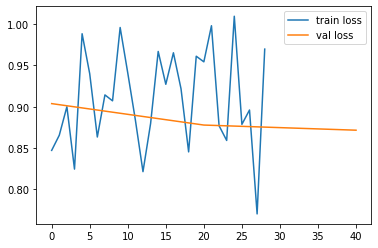

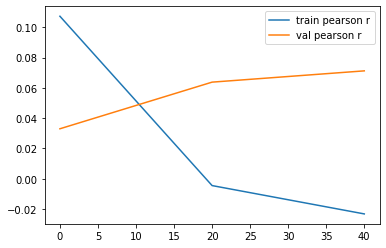

  Average training loss: 0.86
======= Epoch 3 / 50 =======
Iteration 0, loss = 0.8325, loss_val = 0.8563, pearson_r = 0.1259, pearson_r_val = 0.0908, lr = 0.0010000
       - Validation output mean = -0.02683, variance = 0.59305 
       - Validation y mean = -0.02221, variance = 0.82681


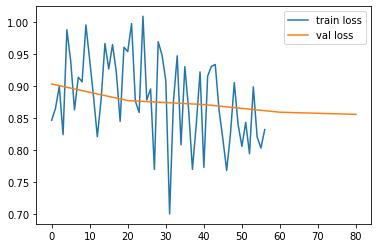

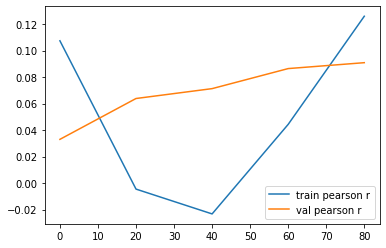

  Average training loss: 0.83
======= Epoch 4 / 50 =======
Iteration 0, loss = 0.7792, loss_val = 0.8479, pearson_r = 0.1807, pearson_r_val = 0.0991, lr = 0.0010000
       - Validation output mean = 0.02695, variance = 0.38936 
       - Validation y mean = -0.02221, variance = 0.82681


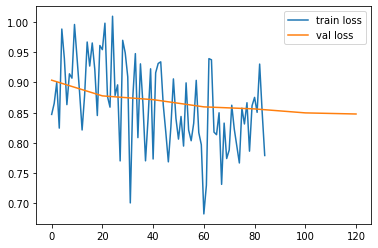

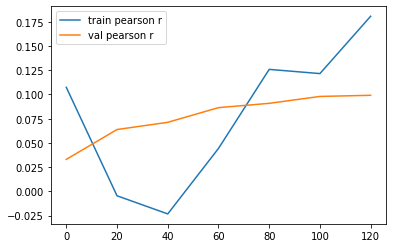

  Average training loss: 0.83
======= Epoch 5 / 50 =======
Iteration 0, loss = 0.8583, loss_val = 0.8391, pearson_r = 0.0923, pearson_r_val = 0.1066, lr = 0.0010000
       - Validation output mean = 0.03126, variance = 0.30501 
       - Validation y mean = -0.02221, variance = 0.82681


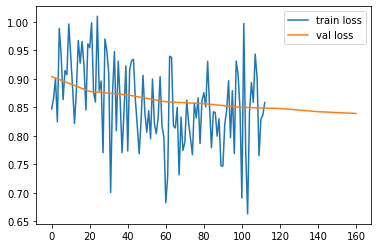

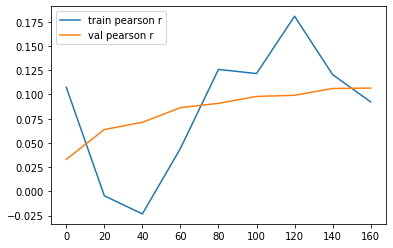

  Average training loss: 0.83
======= Epoch 6 / 50 =======
Iteration 0, loss = 0.9195, loss_val = 0.8472, pearson_r = 0.0268, pearson_r_val = 0.0988, lr = 0.0010000
       - Validation output mean = -0.01059, variance = 0.35302 
       - Validation y mean = -0.02221, variance = 0.82681


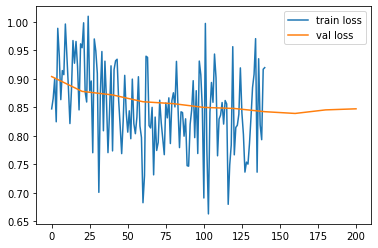

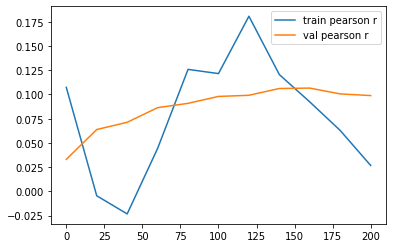

  Average training loss: 0.81
======= Epoch 7 / 50 =======
Iteration 0, loss = 0.9114, loss_val = 0.8404, pearson_r = 0.0346, pearson_r_val = 0.1051, lr = 0.0010000
       - Validation output mean = 0.06903, variance = 0.29948 
       - Validation y mean = -0.02221, variance = 0.82681


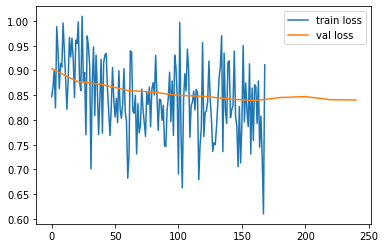

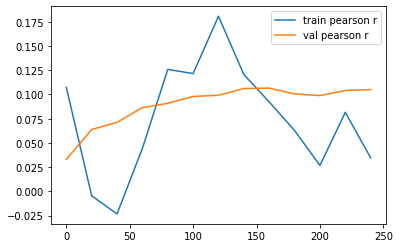

  Average training loss: 0.80
======= Epoch 8 / 50 =======
Iteration 0, loss = 0.9437, loss_val = 0.8427, pearson_r = 0.0018, pearson_r_val = 0.1026, lr = 0.0010000
       - Validation output mean = 0.09788, variance = 0.27257 
       - Validation y mean = -0.02221, variance = 0.82681


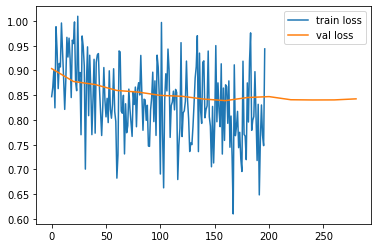

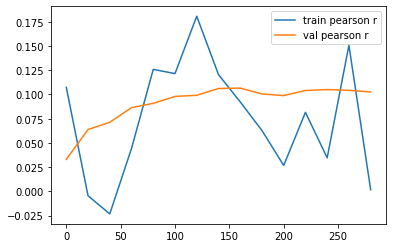

  Average training loss: 0.81
======= Epoch 9 / 50 =======
Iteration 0, loss = 0.7150, loss_val = 0.8433, pearson_r = 0.2499, pearson_r_val = 0.1031, lr = 0.0010000
       - Validation output mean = 0.09896, variance = 0.26911 
       - Validation y mean = -0.02221, variance = 0.82681


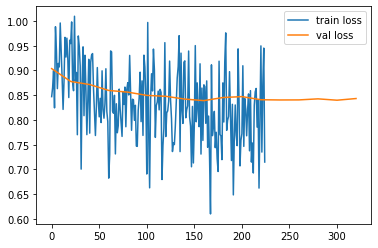

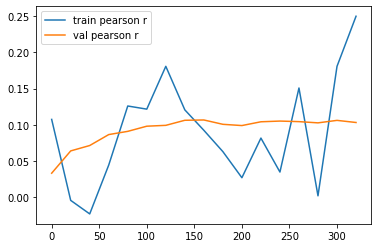

  Average training loss: 0.79
======= Epoch 10 / 50 =======
Iteration 0, loss = 0.7487, loss_val = 0.8391, pearson_r = 0.2134, pearson_r_val = 0.1058, lr = 0.0010000
       - Validation output mean = 0.09819, variance = 0.23961 
       - Validation y mean = -0.02221, variance = 0.82681


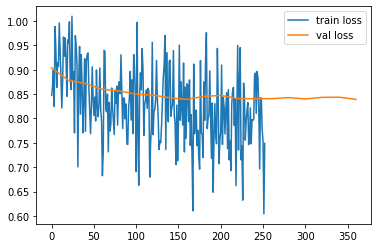

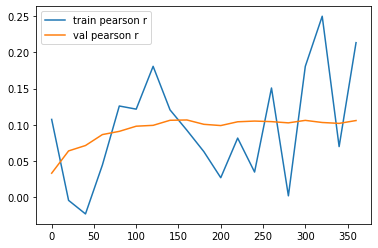

  Average training loss: 0.80
======= Epoch 11 / 50 =======
Iteration 0, loss = 0.8264, loss_val = 0.8268, pearson_r = 0.1260, pearson_r_val = 0.1174, lr = 0.0010000
       - Validation output mean = 0.14014, variance = 0.20667 
       - Validation y mean = -0.02221, variance = 0.82681


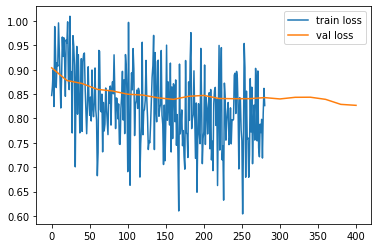

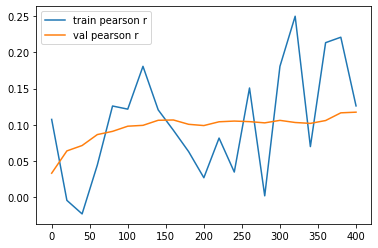

  Average training loss: 0.80
======= Epoch 12 / 50 =======
Iteration 0, loss = 0.7856, loss_val = 0.8291, pearson_r = 0.1762, pearson_r_val = 0.1160, lr = 0.0010000
       - Validation output mean = 0.10221, variance = 0.23896 
       - Validation y mean = -0.02221, variance = 0.82681


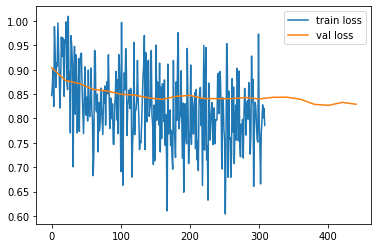

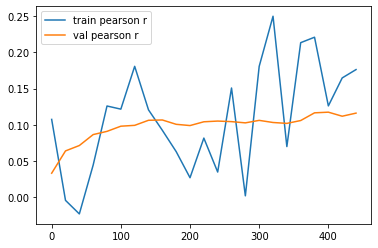

  Average training loss: 0.80
======= Epoch 13 / 50 =======
Iteration 0, loss = 0.8010, loss_val = 0.8325, pearson_r = 0.1584, pearson_r_val = 0.1129, lr = 0.0010000
       - Validation output mean = 0.12975, variance = 0.21813 
       - Validation y mean = -0.02221, variance = 0.82681


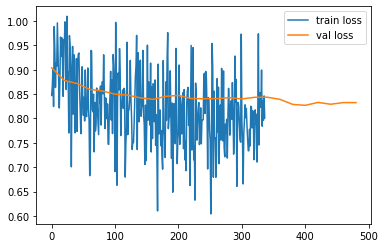

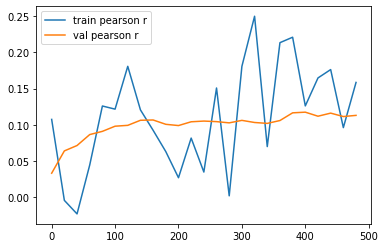

  Average training loss: 0.79
======= Epoch 14 / 50 =======
Iteration 0, loss = 0.7872, loss_val = 0.8287, pearson_r = 0.1701, pearson_r_val = 0.1143, lr = 0.0010000
       - Validation output mean = 0.09798, variance = 0.21714 
       - Validation y mean = -0.02221, variance = 0.82681


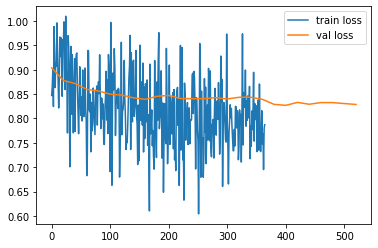

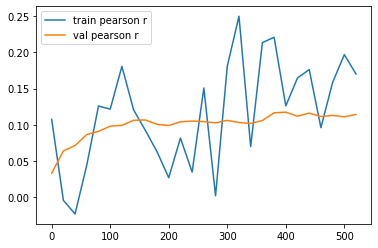

  Average training loss: 0.80
======= Epoch 15 / 50 =======
Iteration 0, loss = 0.7190, loss_val = 0.8222, pearson_r = 0.2467, pearson_r_val = 0.1223, lr = 0.0010000
       - Validation output mean = 0.11406, variance = 0.21695 
       - Validation y mean = -0.02221, variance = 0.82681


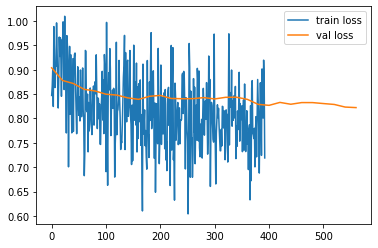

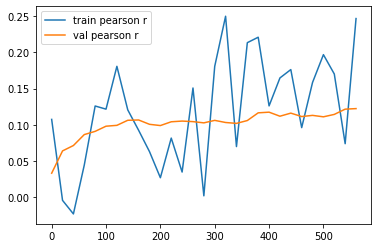

  Average training loss: 0.79
======= Epoch 16 / 50 =======
Iteration 0, loss = 0.7843, loss_val = 0.8183, pearson_r = 0.1747, pearson_r_val = 0.1248, lr = 0.0010000
       - Validation output mean = 0.11897, variance = 0.20793 
       - Validation y mean = -0.02221, variance = 0.82681


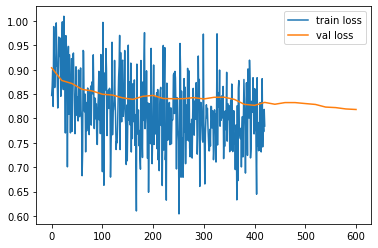

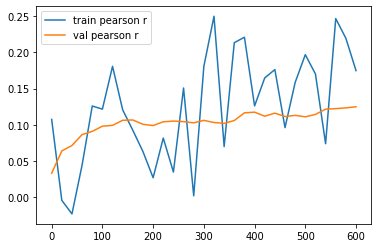

  Average training loss: 0.78
======= Epoch 17 / 50 =======
Iteration 0, loss = 0.8235, loss_val = 0.8227, pearson_r = 0.1286, pearson_r_val = 0.1219, lr = 0.0010000
       - Validation output mean = 0.08281, variance = 0.20881 
       - Validation y mean = -0.02221, variance = 0.82681


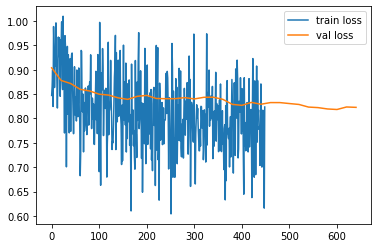

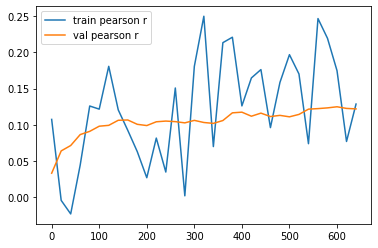

  Average training loss: 0.79
======= Epoch 18 / 50 =======
Iteration 0, loss = 0.7686, loss_val = 0.8279, pearson_r = 0.1884, pearson_r_val = 0.1157, lr = 0.0010000
       - Validation output mean = 0.07181, variance = 0.23024 
       - Validation y mean = -0.02221, variance = 0.82681


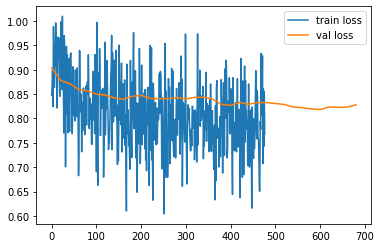

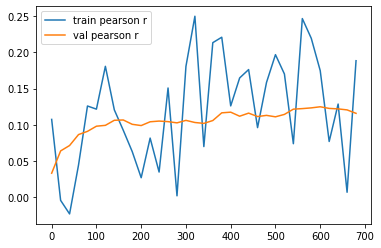

  Average training loss: 0.79
======= Epoch 19 / 50 =======
Iteration 0, loss = 0.7813, loss_val = 0.8271, pearson_r = 0.1781, pearson_r_val = 0.1173, lr = 0.0007000
       - Validation output mean = 0.13627, variance = 0.18606 
       - Validation y mean = -0.02221, variance = 0.82681


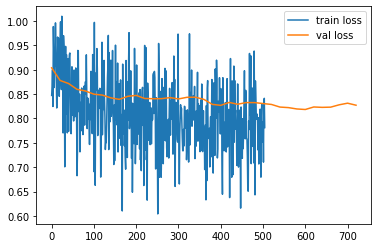

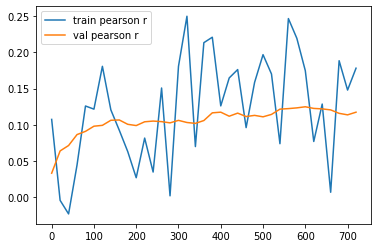

  Average training loss: 0.78
======= Epoch 20 / 50 =======
Iteration 0, loss = 0.7662, loss_val = 0.8248, pearson_r = 0.1912, pearson_r_val = 0.1193, lr = 0.0007000
       - Validation output mean = 0.09721, variance = 0.19476 
       - Validation y mean = -0.02221, variance = 0.82681


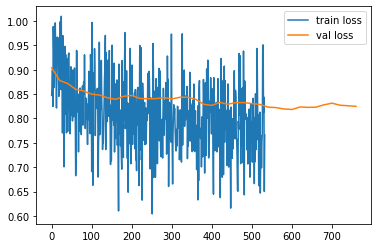

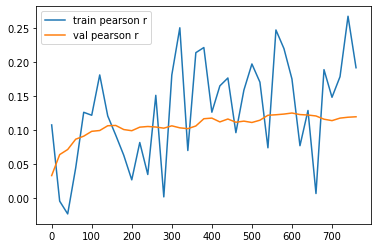

  Average training loss: 0.78
======= Epoch 21 / 50 =======
Iteration 0, loss = 0.6946, loss_val = 0.8204, pearson_r = 0.2712, pearson_r_val = 0.1235, lr = 0.0007000
       - Validation output mean = 0.08817, variance = 0.19027 
       - Validation y mean = -0.02221, variance = 0.82681


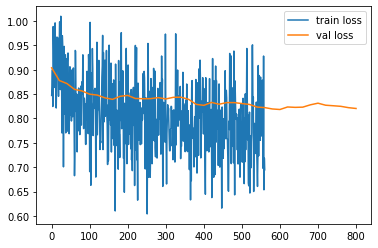

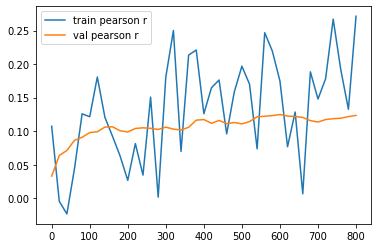

  Average training loss: 0.77
======= Epoch 22 / 50 =======
Iteration 0, loss = 0.7891, loss_val = 0.8151, pearson_r = 0.1666, pearson_r_val = 0.1292, lr = 0.0007000
       - Validation output mean = 0.12163, variance = 0.16969 
       - Validation y mean = -0.02221, variance = 0.82681


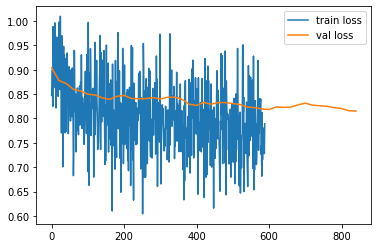

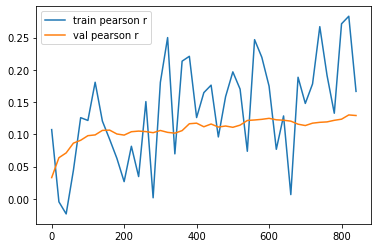

  Average training loss: 0.77
======= Epoch 23 / 50 =======
Iteration 0, loss = 0.6568, loss_val = 0.8178, pearson_r = 0.3118, pearson_r_val = 0.1271, lr = 0.0007000
       - Validation output mean = 0.13305, variance = 0.15561 
       - Validation y mean = -0.02221, variance = 0.82681


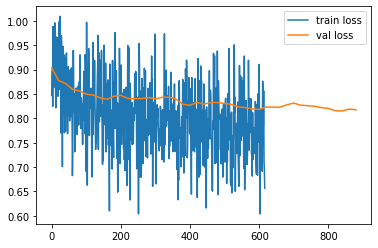

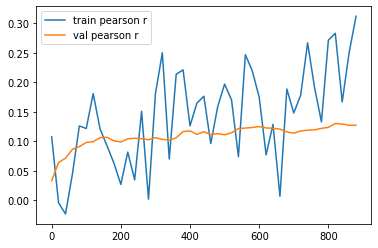

  Average training loss: 0.78
======= Epoch 24 / 50 =======
Iteration 0, loss = 0.8097, loss_val = 0.8204, pearson_r = 0.1422, pearson_r_val = 0.1234, lr = 0.0007000
       - Validation output mean = 0.09004, variance = 0.16039 
       - Validation y mean = -0.02221, variance = 0.82681


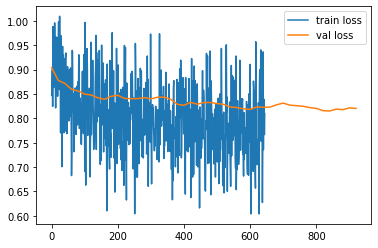

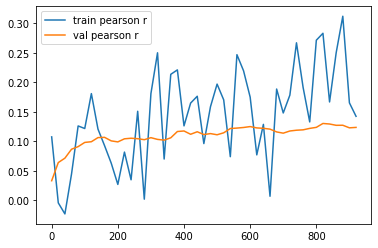

  Average training loss: 0.78
======= Epoch 25 / 50 =======
Iteration 0, loss = 0.7970, loss_val = 0.8167, pearson_r = 0.1588, pearson_r_val = 0.1278, lr = 0.0007000
       - Validation output mean = 0.13894, variance = 0.15144 
       - Validation y mean = -0.02221, variance = 0.82681


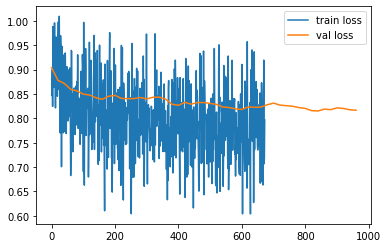

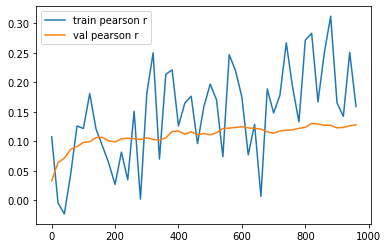

  Average training loss: 0.78
======= Epoch 26 / 50 =======
Iteration 0, loss = 0.6945, loss_val = 0.8180, pearson_r = 0.2703, pearson_r_val = 0.1255, lr = 0.0007000
       - Validation output mean = 0.10412, variance = 0.15877 
       - Validation y mean = -0.02221, variance = 0.82681


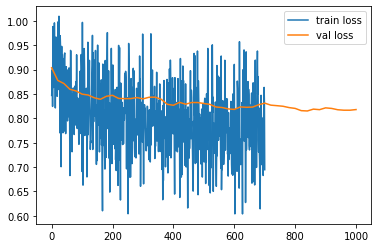

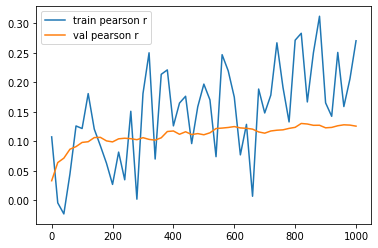

  Average training loss: 0.78
======= Epoch 27 / 50 =======
Iteration 0, loss = 0.7299, loss_val = 0.8203, pearson_r = 0.2273, pearson_r_val = 0.1233, lr = 0.0007000
       - Validation output mean = 0.09251, variance = 0.17224 
       - Validation y mean = -0.02221, variance = 0.82681


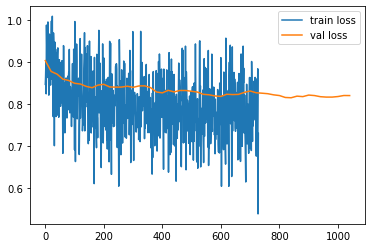

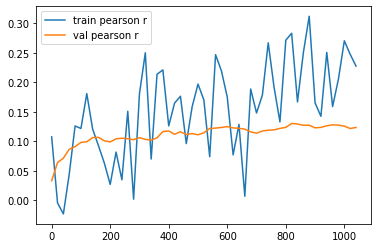

  Average training loss: 0.78
======= Epoch 28 / 50 =======
Iteration 0, loss = 0.8594, loss_val = 0.8175, pearson_r = 0.0928, pearson_r_val = 0.1266, lr = 0.0007000
       - Validation output mean = 0.13231, variance = 0.15936 
       - Validation y mean = -0.02221, variance = 0.82681


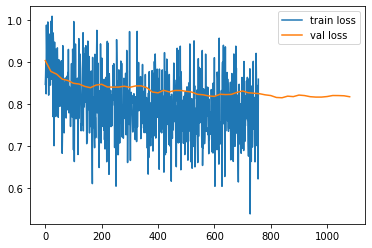

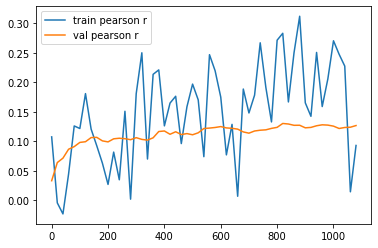

  Average training loss: 0.78
======= Epoch 29 / 50 =======
Iteration 0, loss = 0.7945, loss_val = 0.8176, pearson_r = 0.1554, pearson_r_val = 0.1276, lr = 0.0007000
       - Validation output mean = 0.13590, variance = 0.14971 
       - Validation y mean = -0.02221, variance = 0.82681


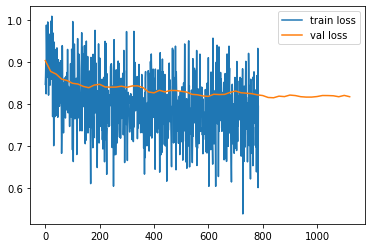

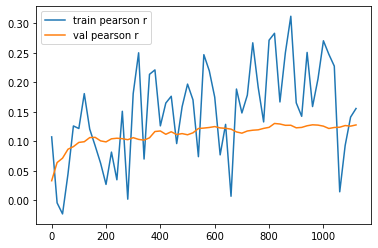

  Average training loss: 0.78
======= Epoch 30 / 50 =======
Iteration 0, loss = 0.7014, loss_val = 0.8166, pearson_r = 0.2583, pearson_r_val = 0.1262, lr = 0.0007000
       - Validation output mean = 0.10405, variance = 0.15314 
       - Validation y mean = -0.02221, variance = 0.82681


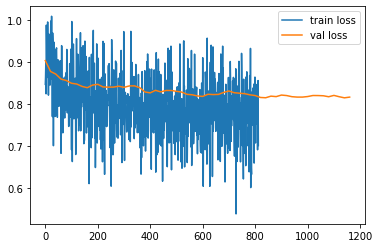

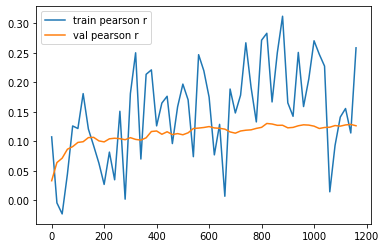

  Average training loss: 0.76
======= Epoch 31 / 50 =======
Iteration 0, loss = 0.8152, loss_val = 0.8230, pearson_r = 0.1330, pearson_r_val = 0.1214, lr = 0.0007000
       - Validation output mean = 0.12342, variance = 0.12962 
       - Validation y mean = -0.02221, variance = 0.82681


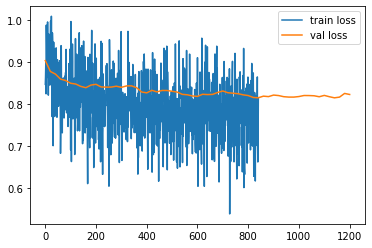

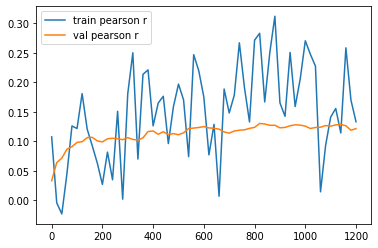

  Average training loss: 0.76
======= Epoch 32 / 50 =======
Iteration 0, loss = 0.8104, loss_val = 0.8197, pearson_r = 0.1384, pearson_r_val = 0.1228, lr = 0.0007000
       - Validation output mean = 0.10851, variance = 0.14291 
       - Validation y mean = -0.02221, variance = 0.82681


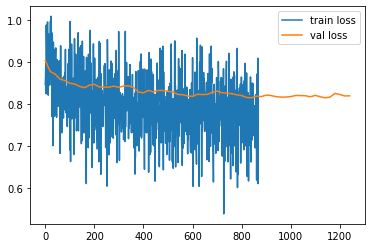

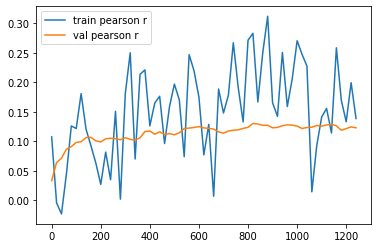

  Average training loss: 0.77
======= Epoch 33 / 50 =======
Iteration 0, loss = 0.8613, loss_val = 0.8179, pearson_r = 0.0834, pearson_r_val = 0.1258, lr = 0.0007000
       - Validation output mean = 0.12916, variance = 0.12536 
       - Validation y mean = -0.02221, variance = 0.82681


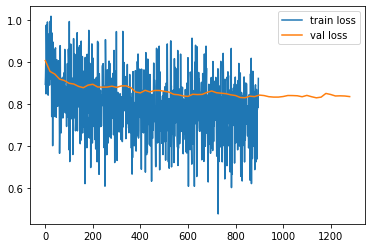

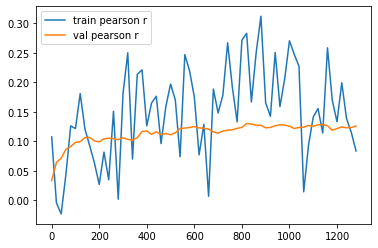

  Average training loss: 0.78
======= Epoch 34 / 50 =======
Iteration 0, loss = 0.6678, loss_val = 0.8196, pearson_r = 0.3046, pearson_r_val = 0.1232, lr = 0.0007000
       - Validation output mean = 0.08945, variance = 0.15403 
       - Validation y mean = -0.02221, variance = 0.82681


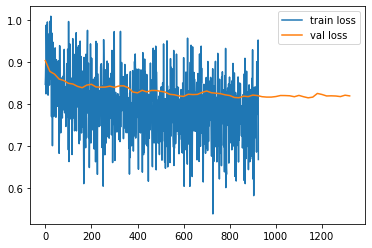

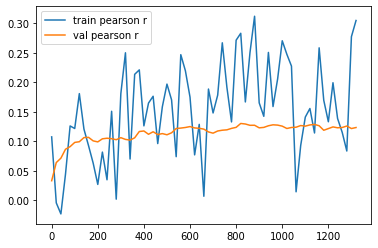

  Average training loss: 0.75
======= Epoch 35 / 50 =======
Iteration 0, loss = 0.7153, loss_val = 0.8168, pearson_r = 0.2508, pearson_r_val = 0.1264, lr = 0.0007000
       - Validation output mean = 0.14947, variance = 0.12953 
       - Validation y mean = -0.02221, variance = 0.82681


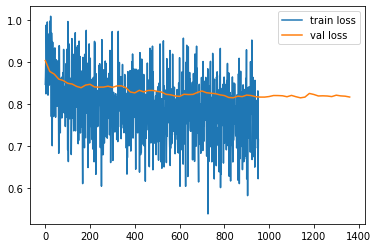

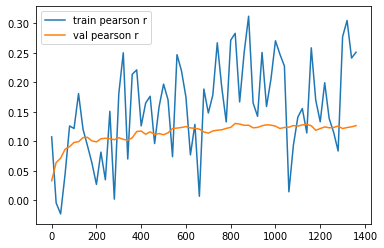

  Average training loss: 0.77
======= Epoch 36 / 50 =======
Iteration 0, loss = 0.7428, loss_val = 0.8204, pearson_r = 0.2098, pearson_r_val = 0.1228, lr = 0.0007000
       - Validation output mean = 0.10108, variance = 0.14073 
       - Validation y mean = -0.02221, variance = 0.82681


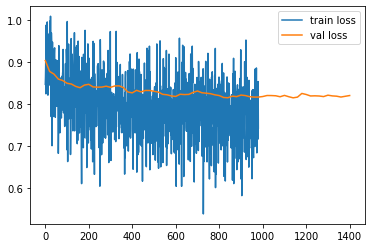

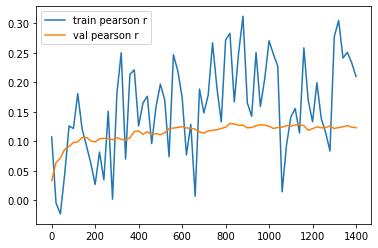

  Average training loss: 0.76
======= Epoch 37 / 50 =======
Iteration 0, loss = 0.6938, loss_val = 0.8218, pearson_r = 0.2686, pearson_r_val = 0.1228, lr = 0.0004900
       - Validation output mean = 0.11041, variance = 0.13663 
       - Validation y mean = -0.02221, variance = 0.82681


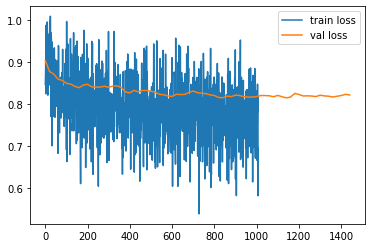

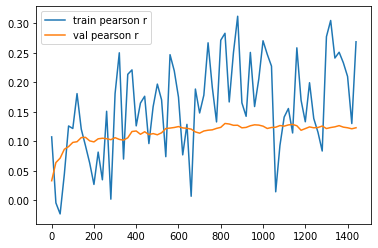

  Average training loss: 0.77
======= Epoch 38 / 50 =======
Iteration 0, loss = 0.8612, loss_val = 0.8227, pearson_r = 0.0952, pearson_r_val = 0.1217, lr = 0.0004900
       - Validation output mean = 0.10449, variance = 0.13554 
       - Validation y mean = -0.02221, variance = 0.82681


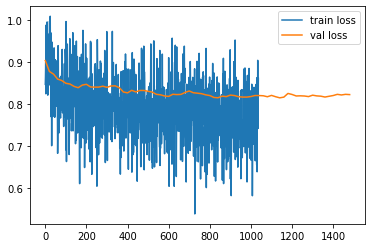

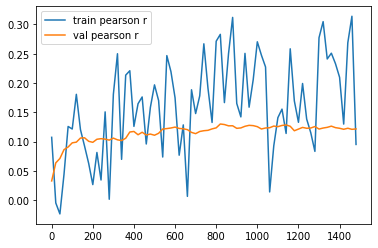

  Average training loss: 0.77
======= Epoch 39 / 50 =======
Iteration 0, loss = 0.7552, loss_val = 0.8204, pearson_r = 0.2065, pearson_r_val = 0.1231, lr = 0.0004900
       - Validation output mean = 0.11695, variance = 0.13249 
       - Validation y mean = -0.02221, variance = 0.82681


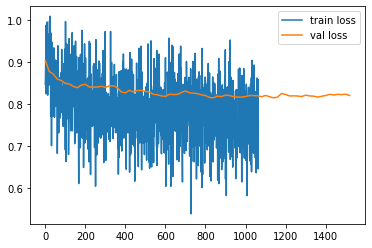

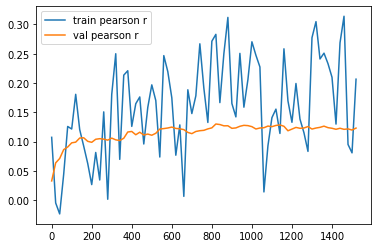

  Average training loss: 0.77
======= Epoch 40 / 50 =======
Iteration 0, loss = 0.8285, loss_val = 0.8156, pearson_r = 0.1292, pearson_r_val = 0.1259, lr = 0.0004900
       - Validation output mean = 0.09765, variance = 0.14261 
       - Validation y mean = -0.02221, variance = 0.82681


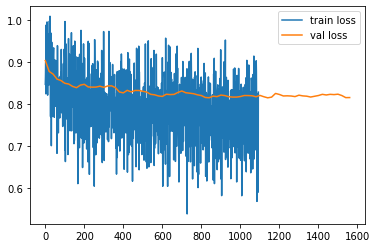

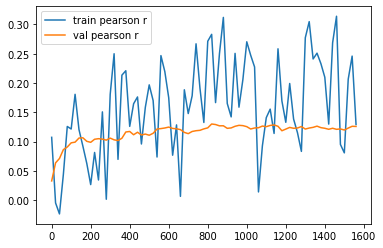

  Average training loss: 0.78
======= Epoch 41 / 50 =======
Iteration 0, loss = 0.8638, loss_val = 0.8179, pearson_r = 0.0800, pearson_r_val = 0.1255, lr = 0.0004900
       - Validation output mean = 0.12410, variance = 0.13770 
       - Validation y mean = -0.02221, variance = 0.82681


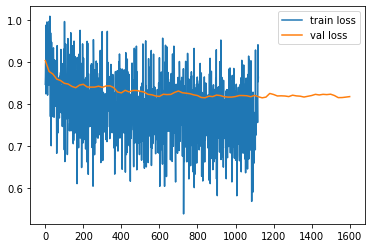

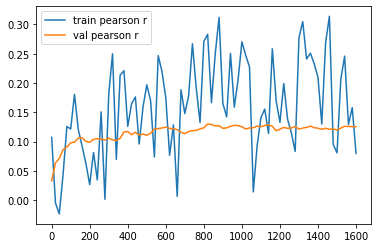

  Average training loss: 0.77
======= Epoch 42 / 50 =======
Iteration 0, loss = 0.7984, loss_val = 0.8193, pearson_r = 0.1574, pearson_r_val = 0.1256, lr = 0.0004900
       - Validation output mean = 0.14311, variance = 0.12930 
       - Validation y mean = -0.02221, variance = 0.82681


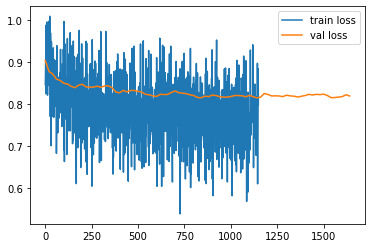

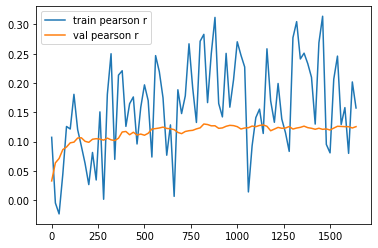

  Average training loss: 0.77
======= Epoch 43 / 50 =======
Iteration 0, loss = 0.6606, loss_val = 0.8179, pearson_r = 0.3050, pearson_r_val = 0.1247, lr = 0.0004900
       - Validation output mean = 0.12204, variance = 0.12955 
       - Validation y mean = -0.02221, variance = 0.82681


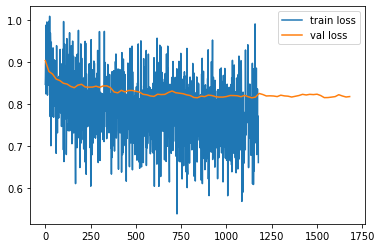

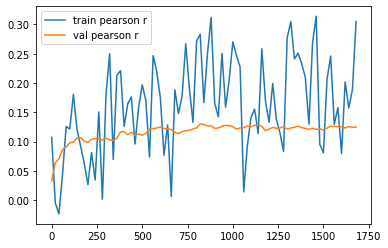

  Average training loss: 0.76
======= Epoch 44 / 50 =======
Iteration 0, loss = 0.7663, loss_val = 0.8220, pearson_r = 0.1834, pearson_r_val = 0.1227, lr = 0.0004900
       - Validation output mean = 0.12925, variance = 0.12279 
       - Validation y mean = -0.02221, variance = 0.82681


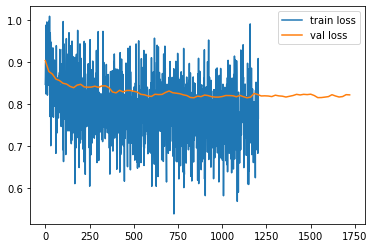

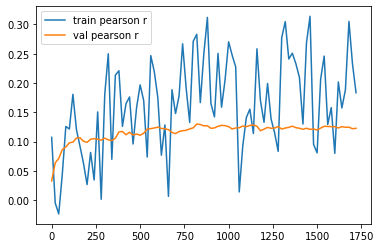

  Average training loss: 0.76
======= Epoch 45 / 50 =======
Iteration 0, loss = 0.8446, loss_val = 0.8212, pearson_r = 0.1047, pearson_r_val = 0.1228, lr = 0.0004900
       - Validation output mean = 0.13106, variance = 0.12092 
       - Validation y mean = -0.02221, variance = 0.82681


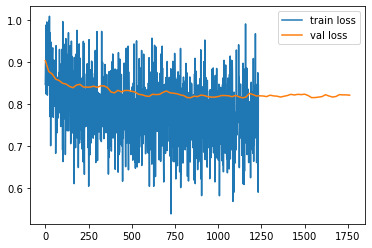

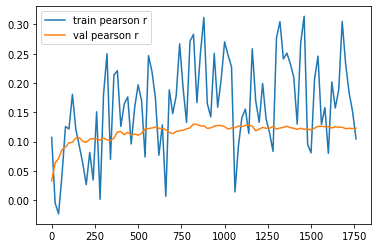

  Average training loss: 0.76
======= Epoch 46 / 50 =======
Iteration 0, loss = 0.6887, loss_val = 0.8186, pearson_r = 0.2817, pearson_r_val = 0.1252, lr = 0.0004900
       - Validation output mean = 0.12147, variance = 0.11944 
       - Validation y mean = -0.02221, variance = 0.82681


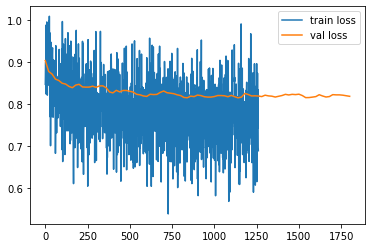

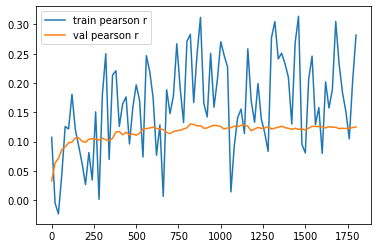

  Average training loss: 0.77
======= Epoch 47 / 50 =======
Iteration 0, loss = 0.7118, loss_val = 0.8168, pearson_r = 0.2518, pearson_r_val = 0.1266, lr = 0.0004900
       - Validation output mean = 0.11970, variance = 0.11779 
       - Validation y mean = -0.02221, variance = 0.82681


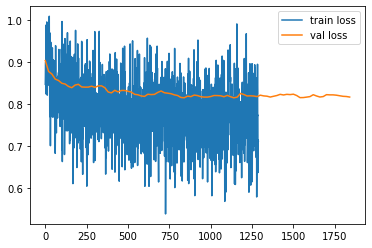

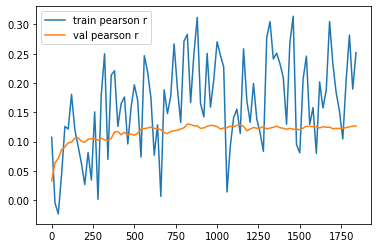

  Average training loss: 0.77
======= Epoch 48 / 50 =======
Iteration 0, loss = 0.7393, loss_val = 0.8159, pearson_r = 0.2203, pearson_r_val = 0.1270, lr = 0.0004900
       - Validation output mean = 0.13385, variance = 0.12143 
       - Validation y mean = -0.02221, variance = 0.82681


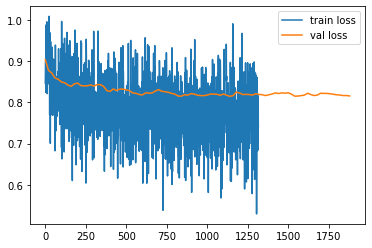

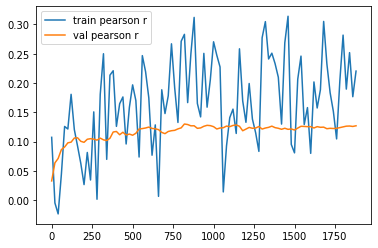

  Average training loss: 0.76
======= Epoch 49 / 50 =======
Iteration 0, loss = 0.7604, loss_val = 0.8153, pearson_r = 0.1968, pearson_r_val = 0.1274, lr = 0.0004900
       - Validation output mean = 0.12509, variance = 0.12283 
       - Validation y mean = -0.02221, variance = 0.82681


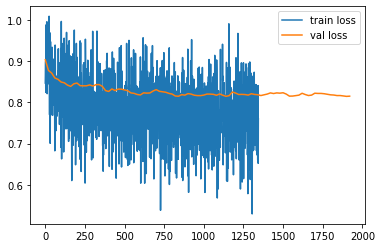

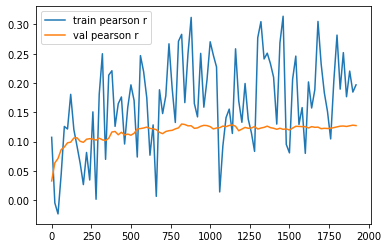

  Average training loss: 0.76
======= Epoch 50 / 50 =======
Iteration 0, loss = 0.6307, loss_val = 0.8221, pearson_r = 0.3334, pearson_r_val = 0.1208, lr = 0.0004900
       - Validation output mean = 0.10900, variance = 0.12381 
       - Validation y mean = -0.02221, variance = 0.82681


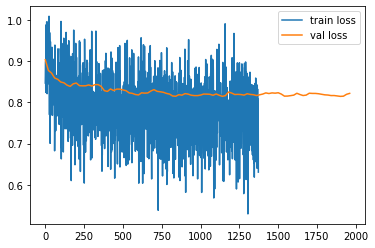

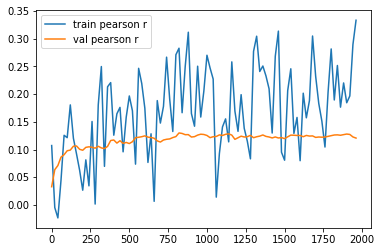

  Average training loss: 0.76


In [54]:
model = FFNNforQualityEstimation(25, 32, 64, 0.05)

loader_train, loader_dev, loader_test, loader_final = get_features(language, batch_size=256)

loss_fn = L1_pearson_loss
beta = 0.1
optimizer = AdamW(model.parameters(), lr=0.001, eps=1e-8)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.7)

train(model, loader_train, loader_dev, optimizer, loss_fn, beta, scheduler, epochs=50)

In [0]:
loader_train, loader_dev, loader_test, loader_final = get_features(language, batch_size=512, shuffle=False)

model_name = 'simple_model'
model_base_name = 'simple_model.pt'

# Evaluate the trained model on train, dev and test data
train_output = get_output(model, loader_train, model_name)
dev_output = get_output(model, loader_dev, model_name)
test_output = get_output(model, loader_test, model_name, test=True)
writeScores(train_output, model_base_name, 'train')
writeScores(dev_output, model_base_name, 'dev')
writeScores(test_output, model_base_name, 'test')

## Ensemble Models

In [0]:
def get_all_scores(all_models, data_type):
    combined_scores = []
    for i in all_models:
        path_to_file = '/content/gdrive/My Drive/Colab Notebooks/predictions_%s_%s.txt' %(i, data_type)
        combined_scores.append(torch.from_numpy(np.genfromtxt(path_to_file, delimiter='/n')).unsqueeze(1))
    return torch.cat(combined_scores, dim=1)

In [39]:
all_models = ['simple_model',
              'QE_model_bert',
              'QE_model_xlm',
              'QE_model_lstm_fasttext',
              'QE_model_lstm_glove'
              ]

all_train_scores = get_all_scores(all_models, 'train')
all_dev_scores = get_all_scores(all_models, 'dev')
all_test_scores = get_all_scores(all_models, 'test')
target_train_scores = torch.from_numpy(np.genfromtxt(os.path.expanduser("./") + 'train.enzh.scores', dtype=np.float64, delimiter='/n')).unsqueeze(1)
target_dev_scores = torch.from_numpy(np.genfromtxt(os.path.expanduser("./") + 'dev.enzh.scores', dtype=np.float64, delimiter='/n')).unsqueeze(1)

print(all_train_scores.shape)
print(target_train_scores.shape)
loader_train = DataLoader(TensorDataset(all_train_scores.type(torch.FloatTensor), target_train_scores.type(torch.FloatTensor)), batch_size=128, shuffle=True)
loader_dev = DataLoader(TensorDataset(all_dev_scores.type(torch.FloatTensor), target_dev_scores.type(torch.FloatTensor)), batch_size=128, shuffle=False)

torch.Size([7000, 5])
torch.Size([7000, 1])


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(all_train_scores[0])
print(target_train_scores[0])


def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

sc = 0
sc2 = 0
for i in range(len(all_models)):
    print(all_models[i])
    print('--------- Dev Pearson R:', scipy.stats.pearsonr(all_dev_scores[:, i], target_dev_scores[:, 0])[0])
    print('--------- Train Pearson R:', scipy.stats.pearsonr(all_train_scores[:, i], target_train_scores[:, 0])[0])
    print('--------- Dev MAE:', mean_absolute_error(all_dev_scores[:, i], target_dev_scores[:, 0]))
    print('--------- Train MAE:', mean_absolute_error(all_train_scores[:, i], target_train_scores[:, 0]))
    print('--------- Dev RMSE:', rmse(all_dev_scores[:, i], target_dev_scores[:, 0]).item())
    print('--------- Train RMSE:', rmse(all_train_scores[:, i], target_train_scores[:, 0]).item())
    sc += scipy.stats.pearsonr(all_dev_scores[:, i], target_dev_scores[:, 0])[0]
    sc2 += scipy.stats.pearsonr(all_train_scores[:, i], target_train_scores[:, 0])[0]
print(sc / len(all_models))
print(sc2/ len(all_models))

tensor([ 0.1362,  0.3399, -0.3508,  0.1137,  0.2975], dtype=torch.float64)
tensor([-1.5284], dtype=torch.float64)
simple_model
--------- Dev Pearson R: 0.13131402861508654
--------- Train Pearson R: 0.24055440306815276
--------- Dev MAE: 0.7051190300314566
--------- Train MAE: 0.68694003915634
--------- Dev RMSE: 0.9290471491796009
--------- Train RMSE: 0.9141809815027178
QE_model_bert
--------- Dev Pearson R: 0.45162948238658623
--------- Train Pearson R: 0.7295820952612062
--------- Dev MAE: 0.61216161472576
--------- Train MAE: 0.513589002522636
--------- Dev RMSE: 0.8515575011917234
--------- Train RMSE: 0.7176880912850907
QE_model_xlm
--------- Dev Pearson R: 0.35925417663345377
--------- Train Pearson R: 0.74858095217207
--------- Dev MAE: 0.6432274375164231
--------- Train MAE: 0.49148255259544943
--------- Dev RMSE: 0.8846116019498285
--------- Train RMSE: 0.6771452461769837
QE_model_lstm_fasttext
--------- Dev Pearson R: 0.29826281101539565
--------- Train Pearson R: 0.4220025

In [58]:
from sklearn.svm import SVR
from scipy.stats.stats import pearsonr

all_models = ['simple_model',
              'QE_model_bert',
              # 'QE_model_xlm',
              # 'QE_model_lstm_fasttext',
              # 'QE_model_lstm_glove'
              ]

all_train_scores = get_all_scores(all_models, 'train')
all_dev_scores = get_all_scores(all_models, 'dev')
all_test_scores = get_all_scores(all_models, 'test')
target_train_scores = torch.from_numpy(np.genfromtxt(os.path.expanduser("./") + 'train.enzh.scores', dtype=np.float64, delimiter='/n')).unsqueeze(1)
target_dev_scores = torch.from_numpy(np.genfromtxt(os.path.expanduser("./") + 'dev.enzh.scores', dtype=np.float64, delimiter='/n')).unsqueeze(1)



for k in ['linear', 'rbf', 'sigmoid']:
    clf_t = SVR(kernel=k)
    clf_t.fit(all_train_scores, target_train_scores.flatten())
    print(k)
    predictions = clf_t.predict(all_dev_scores)
    pearson = pearsonr(predictions, target_dev_scores.flatten().numpy())[0]
    print('------ pearson r=', pearson)
    print('------ mae=', mean_absolute_error(predictions, target_dev_scores.flatten().numpy()))
    print('------ rmse=', rmse(predictions, target_dev_scores.flatten().numpy()))


linear
------ pearson r= 0.4521220548988675
------ mae= 0.6338956583185209
------ rmse= 0.8380998800137933
rbf
------ pearson r= 0.43322498366484247
------ mae= 0.6284284124564804
------ rmse= 0.8633405317278727
sigmoid
------ pearson r= -0.19090652185547546
------ mae= 183.9890372949443
------ rmse= 237.02561094379152
